# Retrieving Data + packages

In [2]:
import os
import pandas as pd
import numpy as np
import regex as re

In [ ]:
pip install geopandas

In [5]:
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
from wordcloud import WordCloud

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import PorterStemmer 
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
os.listdir('drive/MyDrive/Stuff other app')

['Copie de yelp_academic_dataset_business.csv',
 'Copie de yelp_academic_dataset_checkin.csv',
 'Copie de yelp_academic_dataset_review.csv',
 'Copie de yelp_academic_dataset_tip.csv',
 'Copie de yelp_academic_dataset_user.csv']

In [ ]:
os.chdir('drive/MyDrive/Stuff other app')

review = pd.read_csv('Copie de yelp_academic_dataset_review.csv', index_col=0)
business = pd.read_csv('Copie de yelp_academic_dataset_business.csv', index_col=0)
checkin = pd.read_csv('Copie de yelp_academic_dataset_checkin.csv', index_col=0)
tip = pd.read_csv('Copie de yelp_academic_dataset_tip.csv', index_col=0)
user = pd.read_csv('Copie de yelp_academic_dataset_user.csv', index_col=0)

# Business table

## Overview

In [10]:
business.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
0,921 Pearl St,"Row(AcceptsInsurance=None, AgesAllowed=None, A...",6iYb2HFDywm3zjuRg0shjw,"Gastropubs, Food, Beer Gardens, Restaurants, B...",Boulder,"Row(Friday='11:0-23:0', Monday='11:0-23:0', Sa...",1,40.017544,-105.283348,Oskar Blues Taproom,80302,86,4.0,CO
1,7000 NE Airport Way,"Row(AcceptsInsurance=None, AgesAllowed=None, A...",tCbdrRPZA0oiIYSmHG3J0w,"Salad, Soup, Sandwiches, Delis, Restaurants, C...",Portland,"Row(Friday='5:0-18:0', Monday='5:0-18:0', Satu...",1,45.588906,-122.593331,Flying Elephants at PDX,97218,126,4.0,OR
2,4720 Hawthorne Ave,"Row(AcceptsInsurance=None, AgesAllowed=None, A...",bvN78flM8NLprQ1a1y5dRg,"Antiques, Fashion, Used, Vintage & Consignment...",Portland,"Row(Friday='11:0-18:0', Monday=None, Saturday=...",1,45.511907,-122.613693,The Reclaimory,97214,13,4.5,OR
3,2566 Enterprise Rd,"Row(AcceptsInsurance=None, AgesAllowed=None, A...",oaepsyvc0J17qwi8cfrOWg,"Beauty & Spas, Hair Salons",Orange City,NaN,1,28.914482,-81.295979,Great Clips,32763,8,3.0,FL
4,1046 Memorial Dr SE,"Row(AcceptsInsurance=None, AgesAllowed=None, A...",PE9uqAjdw0E4-8mjGl3wVA,"Gyms, Active Life, Interval Training Gyms, Fit...",Atlanta,"Row(Friday='16:0-19:0', Monday='16:0-19:0', Sa...",1,33.747027,-84.353424,Crossfit Terminus,30316,14,4.0,GA


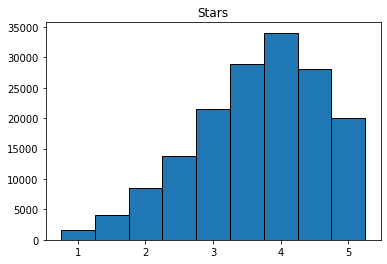

In [11]:
business.city.value_counts() # 836 cities
plt.bar(business.stars.value_counts().index, business.stars.value_counts(), edgecolor='black', width=0.5)
_=plt.title('Stars')

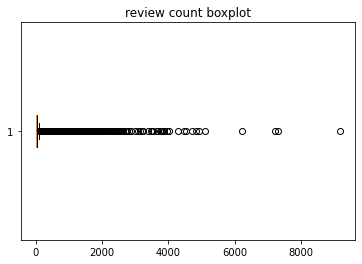

In [12]:
plt.boxplot(business.review_count, vert=False)
_=plt.title('review count boxplot')

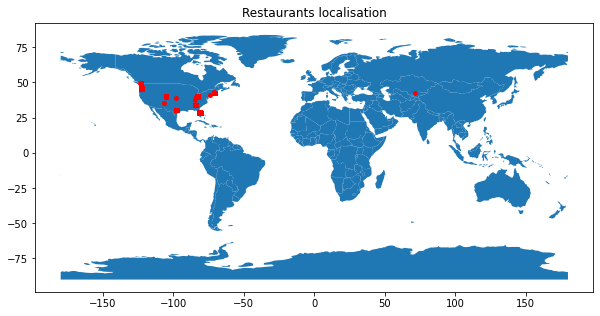

In [ ]:
geometry = [Point(xy) for xy in zip(business['longitude'], business['latitude'])]
gdf = GeoDataFrame(business, geometry=geometry)   

# this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15)
_=plt.title('Restaurants localisation')

One of the first things that we'll need to do is creating clusters of businesses. Right ot the bat, we can see that the columns attributes, categories and hours can be usefull for doing that

## Attributes column

In [ ]:
business.attributes[0]

'Row(AcceptsInsurance=None, AgesAllowed=None, Alcohol="\'beer_and_wine\'", Ambience="{\'touristy\': False, \'hipster\': False, \'romantic\': False, \'divey\': False, \'intimate\': False, \'trendy\': False, \'upscale\': False, \'classy\': False, \'casual\': True}", BYOB=None, BYOBCorkage=None, BestNights=None, BikeParking=\'True\', BusinessAcceptsBitcoin=\'False\', BusinessAcceptsCreditCards=\'True\', BusinessParking="{\'garage\': False, \'street\': True, \'validated\': False, \'lot\': False, \'valet\': False}", ByAppointmentOnly=None, Caters=\'True\', CoatCheck=None, Corkage=None, DietaryRestrictions=None, DogsAllowed=\'False\', DriveThru=None, GoodForDancing=None, GoodForKids=None, GoodForMeal="{\'dessert\': False, \'latenight\': False, \'lunch\': False, \'dinner\': False, \'brunch\': False, \'breakfast\': False}", HairSpecializesIn=None, HappyHour=\'True\', HasTV=\'True\', Music=None, NoiseLevel="u\'average\'", Open24Hours=None, OutdoorSeating=\'True\', RestaurantsAttire="\'casual\'"

In [13]:
# this function allows for the extraction of of all the attributes available in this column

def new_stktk(i, z) :
    try :
        z = re.sub(r'=', ':', z)
    except :
        return 'mouk'
    
    thing = re.compile(r'\W')
    match_sub = ' '
    
    if i == 0 :
        l = re.findall('(?<={}:).*(?=, {}:)'.format(keys[0], keys[1]), z)
        return thing.sub(match_sub, l[0]).strip()
    if i == 38 :
        l = re.findall('(?<= {}:).*'.format(keys[-1]), z)
        return thing.sub(match_sub, l[0]).strip()
    
    l = re.findall('(?<= {}:).*(?=, {}:)'.format(keys[i], keys[i+1]), z)
    if l[0][1] == '{' :
        lol = re.split(': |, ', l[0][2:-2])
        n = len(lol)
        s = ''
        try :
            for j in range(0, n, 2) :
                if lol[j+1] == 'True' :
                    s += lol[j][1:-1] + ' '
        except :
            return 'mouk'
        if s == '' :
            return 'None'
        else :
            return s.strip()
    else :
        return thing.sub(match_sub, l[0]).strip()

# attributes names 
text = business.attributes[0]
keys = re.findall(r'(?<= )[a-zA-Z0-9]*(?=:)', text)
keys = ['AcceptsInsurance'] + keys
keys = ['"' + l + '"' for l in keys]
keys = [elt[1:-1] for elt in keys]

# attributes extraction
attributes = business.attributes.apply(lambda z: new_stktk(0, z))
attributes.name = keys[0]

for i in range(1, len(keys)) :
    y = business.attributes.apply(lambda z: new_stktk(i, z))
    y.name = keys[i]
    attributes = pd.concat([attributes, y], axis=1)

attributes.head()

,AcceptsInsurance_False,AcceptsInsurance_None,AcceptsInsurance_True,AgesAllowed_18plus,AgesAllowed_19plus,AgesAllowed_21plus,AgesAllowed_None,AgesAllowed_allages,Alcohol_None,Alcohol_beer_and_wine,Alcohol_full_bar,BYOB_False,BYOB_None,BYOB_True,BYOBCorkage_None,BYOBCorkage_yes_corkage,BYOBCorkage_yes_free,BikeParking_False,BikeParking_None,BikeParking_True,BusinessAcceptsBitcoin_False,BusinessAcceptsBitcoin_None,BusinessAcceptsBitcoin_True,BusinessAcceptsCreditCards_False,BusinessAcceptsCreditCards_None,BusinessAcceptsCreditCards_True,ByAppointmentOnly_False,ByAppointmentOnly_None,ByAppointmentOnly_True,Caters_False,Caters_None,Caters_True,CoatCheck_False,CoatCheck_None,CoatCheck_True,Corkage_False,Corkage_None,Corkage_True,DogsAllowed_False,DogsAllowed_None,...,Ambience_upscale,Ambience_classy,Ambience_casual,BusinessParking_garage,BusinessParking_street,BusinessParking_validated,BusinessParking_lot,BusinessParking_valet,BestNights_monday,BestNights_tuesday,BestNights_wednesday,BestNights_thursday,BestNights_friday,BestNights_saturday,BestNights_sunday,Music_dj,Music_live,Music_background_music,Music_jukebox,Music_live.1,Music_video,Music_karaoke,GoodForMeal_dessert,GoodForMeal_latenight,GoodForMeal_lunch,GoodForMeal_dinner,GoodForMeal_brunch,GoodForMeal_breakfast,HairSpecializesIn_straightperms,HairSpecializesIn_coloring,HairSpecializesIn_extensions,HairSpecializesIn_africanamerican,HairSpecializesIn_curly,HairSpecializesIn_kids,HairSpecializesIn_perms,HairSpecializesIn_asian,DietaryRestrictions_vegan,DietaryRestrictions_gluten-free,DietaryRestrictions_vegeterian,DietaryRestrictions_dairy-free
0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,1,0,...,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,...,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Categories column

In [15]:
from collections import Counter

def count(data, column) :
    return Counter([thing.strip() for thing in data[column].fillna('missing') for thing in thing.split(',')])

categories_count = count(business, 'categories') # the occurrence of each category in the dataset

In [16]:
len(sorted(categories_count))

1331

## Hours column

In [17]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# This function allows to extract the opening/closing time for each business

def hours_stktk(day, z, what='start') :
    try :
        z = re.sub(r'=', ':', z)
    except :
        return 'None'

    if what == 'start' :
        l = re.findall('(?<={}:\')[0-9:]*(?=-)'.format(day), z)
        if l == [] : 
            return 'None'
        l = [int(k) for k in l[0].split(':')]
        return l[0] + l[1]/60
    l = re.findall('(?<={}:\'[0-9:]*-)[0-9:]*(?=\')'.format(day), z)
    if l == [] :
        return 'None'
    l = [int(k) for k in l[0].split(':')]
    return l[0] + l[1]/60

def construct_hours() :
    stuff = business.hours.apply(lambda z: hours_stktk('Monday', z, what='start'))
    stuff.name = 'Monday' + '_' + 'start'
    y = business.hours.apply(lambda z: hours_stktk('Monday', z, what='end'))
    y.name = 'Monday' + '_' + 'end'
    
    stuff = pd.concat([stuff, y], axis=1)
    
    what = ['start', 'end']
    for day in days[1:] :
        for when in what :
            y = business.hours.apply(lambda z: hours_stktk(day, z, what=when))
            y.name = day + '_' + when
            stuff = pd.concat([stuff, y], axis=1)
    
    return stuff

timings = construct_hours()

In [18]:
## These are features that we thought were relevant to extract, we will choose the appropriate ones for later analysis

# schedule availability column

mask = timings.Monday_start.apply(lambda z: isinstance(z, float))

for column in timings.columns[1:] :
    mask = mask | timings[column].apply(lambda z: isinstance(z, float))
    
timings['available'] = mask.astype(int)

# weekend availability column

mask = timings.Saturday_start.apply(lambda z: isinstance(z, float))

for column in timings.columns[-4:-1] :
    mask = mask | timings[column].apply(lambda z: isinstance(z, float))
    
timings['available_weekend'] = mask.astype(int)

# during the week availability column

mask = timings.Monday_start.apply(lambda z: isinstance(z, float))

for column in timings.columns[1:10] :
    mask = mask | timings[column].apply(lambda z: isinstance(z, float))
    
timings['available_during_week'] = mask.astype(int)

# availability per day columns

i=0
for day in days :
    mask = timings.iloc[:, i].apply(lambda z: isinstance(z, float))
    timings[day+'_availability'] = mask.astype(int)
    i += 2

# opening duration per day columns

def subs(x, y) :
    if x<=y :
        return y-x
    return 24+y-x

i=0
for day in days :
    mask = timings[day+'_availability'] == 1
    
    cols = timings.iloc[:, i:i+2].replace('None', 0)
    timings[day+'_open_duration'] = cols.apply(lambda z: subs(z[day+'_start'], z[day+'_end']), axis=1)
    i += 2

# average opening duration column

timings['mean_open_duration'] = timings.loc[:, 'Monday_open_duration':'Sunday_open_duration'].mean(axis=1)

# average opening time column

timings['avg_opening_hour'] = timings.loc[:, [l+'_start' for l in days]].replace('None', np.nan).mean(axis=1, skipna=True)
timings['avg_opening_hour'].fillna(timings['avg_opening_hour'].mean(), inplace=True)

# average closing time column

timings['avg_closing_hour'] = timings.loc[:, [l+'_end' for l in days]].replace('None', np.nan).mean(axis=1, skipna=True)
timings['avg_closing_hour'].fillna(timings['avg_closing_hour'].mean(), inplace=True)

In [19]:
timings.head()

,Monday_start,Monday_end,Tuesday_start,Tuesday_end,Wednesday_start,Wednesday_end,Thursday_start,Thursday_end,Friday_start,Friday_end,Saturday_start,Saturday_end,Sunday_start,Sunday_end,available,available_weekend,available_during_week,Monday_availability,Tuesday_availability,Wednesday_availability,Thursday_availability,Friday_availability,Saturday_availability,Sunday_availability,Monday_open_duration,Tuesday_open_duration,Wednesday_open_duration,Thursday_open_duration,Friday_open_duration,Saturday_open_duration,Sunday_open_duration,mean_open_duration,avg_opening_hour,avg_closing_hour
0,11,23,11,23,11,23,11,23,11,23,11,23,11,23,1,1,1,1,1,1,1,1,1,1,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.000000,11.000000,23.000000
1,5,18,5,17,5,18,5,18,5,18,5,18,5,18,1,1,1,1,1,1,1,1,1,1,13.0,12.0,13.0,13.0,13.0,13.0,13.0,12.857143,5.000000,17.857143
2,None,None,None,None,None,None,11,18,11,18,11,18,11,18,1,1,1,0,0,0,1,1,1,1,0.0,0.0,0.0,7.0,7.0,7.0,7.0,4.000000,11.000000,18.000000
3,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,9.086513,16.349385
4,16,19,16,19,16,19,16,19,16,19,9,11,None,None,1,1,1,1,1,1,1,1,1,0,3.0,3.0,3.0,3.0,3.0,2.0,0.0,2.428571,14.833333,17.666667


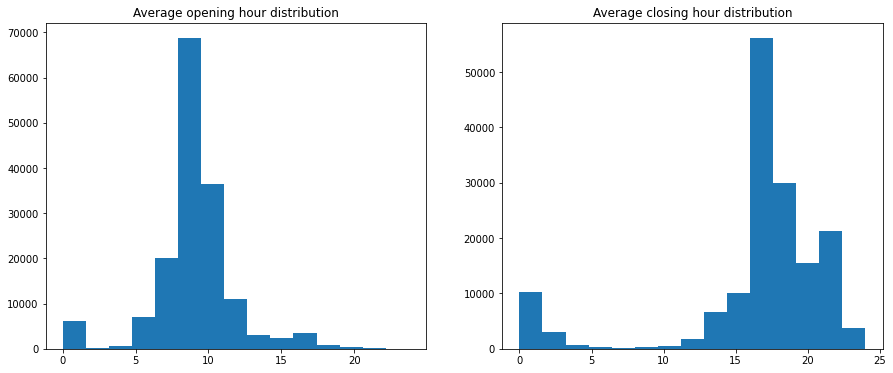

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].hist(timings.avg_opening_hour, bins=15)
_=ax[0].set_title('Average opening hour distribution')

ax[1].hist(timings.avg_closing_hour, bins=15)
_=ax[1].set_title('Average closing hour distribution')

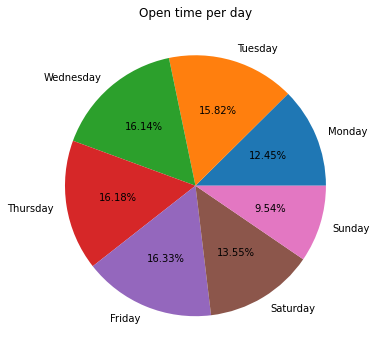

In [21]:
plt.figure(figsize=(10,6))

cols = [day+'_open_duration' for day in days]
durations = timings.loc[:, cols].sum()
plt.pie(durations, labels = days, autopct='%1.2f%%')
_=plt.title('Open time per day')

# Clustering

Now, for the 'variables' extracted from the attributes column. We noticed that there are certain attributes that are specific to restaurants/bars. An idea would be to first separate the businesses based on these attributes, and then create clusters based on each sub group.

In [22]:
# Getting the relevant columns
mask1 = [('Restaurants' in l) or ('Dietary' in l) & ('None' not in l) for l in attributes.columns]
restos_columns = [b for a, b in  zip(mask1, attributes.columns) if a]

mask2 = [('None' not in l) & ('Price' not in l) for l in restos_columns]
restos_columns = [b for a, b in  zip(mask2, restos_columns) if a]

# Non restaurants/bars
non_restos_columns = list(set(attributes.columns)-set(restos_columns))
mask3 = [('None' not in l) for l in non_restos_columns]
non_restos_columns = [b for a, b in  zip(mask3, non_restos_columns) if a]

# Businesses for which the categories are not provided
mask = (business['categories'].isna()==False)

resto_bar = (attributes[mask][restos_columns].sum(axis=1) > 0)

# Selected variables for the clustering
timings_clustering = timings.loc[:,['avg_opening_hour', 'mean_open_duration', 'available_weekend', 'available_during_week']][mask]

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.3)
business_no_na = business[mask]

In [25]:
########
## For restaurants/bars
########

business_resto_bar = business_no_na[resto_bar]
X = vectorizer.fit_transform(business_resto_bar['categories'].values)

all_var = timings_clustering[resto_bar]
all_var = pd.concat([pd.DataFrame(X.todense()), all_var.reset_index(drop=True)], axis=1).values

from sklearn.cluster import KMeans
model = KMeans(n_clusters=3)
model.fit(all_var)
labels = model.labels_
categories_cluster = pd.DataFrame(list(zip(business_resto_bar['categories'],business_resto_bar['business_id'],labels)),columns=['business','id','cluster'])

Cluster: 0


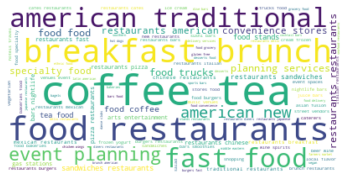

Cluster: 1


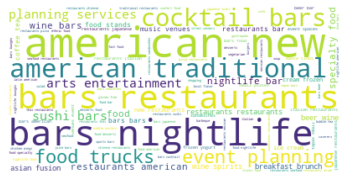

Cluster: 2


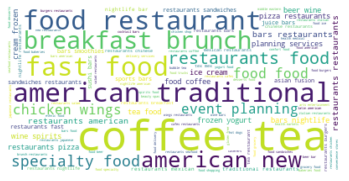

In [26]:
from wordcloud import WordCloud
result={'cluster':labels,'real':business_resto_bar['categories']}
result=pd.DataFrame(result)
for k in range(0,3):
   s=result[result.cluster==k]
   text=s['real'].str.cat(sep=' ')
   text=text.lower()
   text=' '.join([word for word in text.split()])
   wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
   print('Cluster: {}'.format(k))
   plt.figure()
   plt.imshow(wordcloud, interpolation="bilinear")
   plt.axis("off")
   plt.show()

In [27]:
for k in range(0,3):
   s=result[result.cluster==k]
   print(len(s))

13654
12677
35876


In [28]:
########
## Other
########

business_other = business_no_na[~resto_bar]
X = vectorizer.fit_transform(business_other['categories'].values)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
timings_scaled = pd.DataFrame(scaler.fit_transform(timings_clustering[~resto_bar]))

others = attributes[non_restos_columns][mask][~resto_bar]
all_others = pd.concat([pd.DataFrame(X.todense()), others.reset_index(drop=True), timings_scaled], axis=1).values

from sklearn.cluster import KMeans
model = KMeans(n_clusters=4)
model.fit(all_others)
labels = model.labels_
categories_cluster = pd.DataFrame(list(zip(business_other['categories'],business_other['business_id'],labels)),columns=['business','id','cluster'])

Cluster: 0


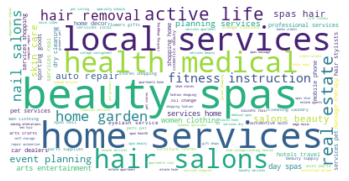

Cluster: 1


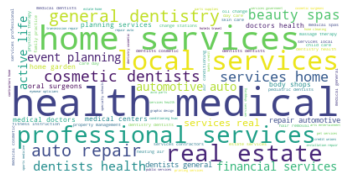

Cluster: 2


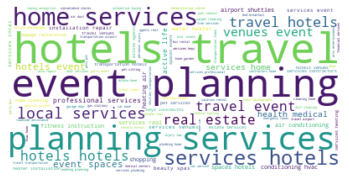

Cluster: 3


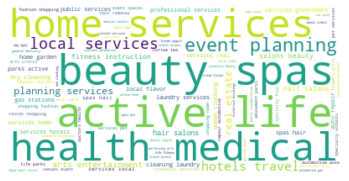

In [29]:
from wordcloud import WordCloud
result={'cluster':labels,'real':business_other['categories']}
result=pd.DataFrame(result)
for k in range(0,4):
    s=result[result.cluster==k]
    text=s['real'].str.cat(sep=' ')
    text=text.lower()
    text=' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    print('Cluster: {}'.format(k))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [30]:
for k in range(0,4):
    s=result[result.cluster==k]
    print(len(s))

57906
17112
4807
18438
